In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import powerlaw
import matplotlib.pyplot as plt
import multiprocessing as mp
import pickle
from tqdm import tqdm

Mean degree: 9.995
Calculating best minimal value for power law fit
Estimated power law exponent: 2.82887146988854


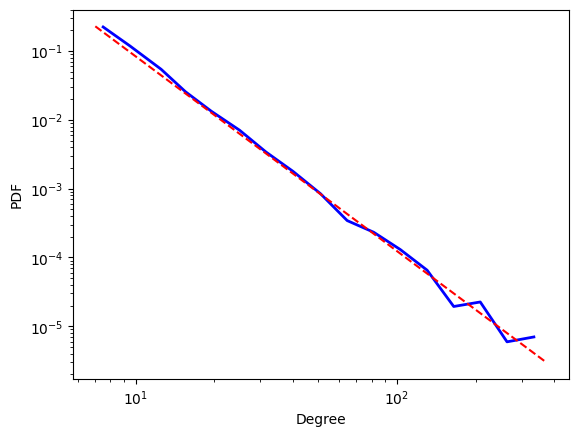

In [22]:
# Parameters for the scale-free network
alpha = 0.2  # Probability of adding a new node connected to an existing node (in-degree)
beta = 0.7 # Probability of adding an edge between two existing nodes
gamma = 0.1  # Probability of adding a new node connected to an existing node (out-degree)

# Generate the network
#g = nx.scale_free_graph(100_000, alpha=alpha, beta=beta, gamma=gamma)
#g = g.to_undirected()

g = nx.barabasi_albert_graph(10_000, 5)

# Get the in-degree distribution
degrees = [d for n, d in g.degree()]
print(f"Mean degree: {np.mean(degrees)}")

# Fit the degree distribution to a power law
fit = powerlaw.Fit(degrees, discrete=True)
print(f"Estimated power law exponent: {fit.power_law.alpha}")

# Plot the degree distribution
fig = fit.plot_pdf(color='b', linestyle='-', linewidth=2)
fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig)
plt.xlabel('Degree')
plt.ylabel('PDF')
plt.show()


In [2]:
N = 10_000
f = 1/N
iterations = 1e6
n_cores = mp.cpu_count()

networks = [
    nx.barabasi_albert_graph(10_000, 5), 
    nx.barabasi_albert_graph(10_000, 1),
    nx.erdos_renyi_graph(10_000, 0.0007),
    nx.erdos_renyi_graph(10_000, 0.002),
    nx.scale_free_graph(10_000, 0.1, 0.1, 0.8).to_undirected(),
    nx.scale_free_graph(10_000, 0.35, 0.3, 0.35).to_undirected(),
    nx.scale_free_graph(10_000, 0.4, 0.1, 0.5).to_undirected(),
    nx.scale_free_graph(10_000, 0.2, 0.7, 0.1).to_undirected(),
]

labels = [
    "BA_5", 
    "BA_1", 
    "ER_0-0007", 
    "ER_0-002", 
    "SF_0-1_0-1_0-8", 
    "SF_0-35_0-3_0-35", 
    "SF_0-4_0-1_0-5", 
    "SF_0-2_0-7_0-1"
]

inputs = [(networks[i], labels[i], f, iterations) for i in range(len(networks))]

In [ ]:
with open("temp_data/ER_0-0007.csv", "rb") as f:
    res = pd.read_csv(f)

print(len(res))

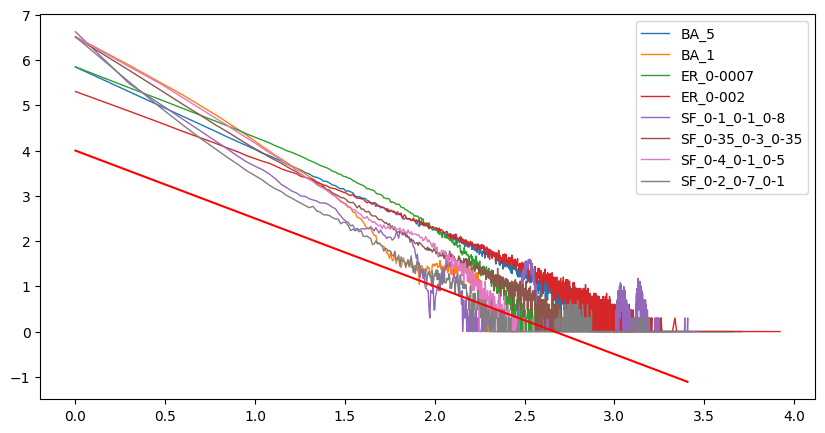

In [9]:
plt.figure(figsize=(10, 5))
for i in range(len(labels)):
    with open(f"temp_data/{labels[i]}.csv", "rb") as f:
        res = pd.read_csv(f)
    area = res.groupby("A", as_index=False).count()
    
    x, y = np.log10(area["A"]), np.log10(area["iteration"])
    plt.plot(x, y, label=labels[i], lw=1)
    

plt.plot(x, -1.5*x+4, c='r')
plt.legend()


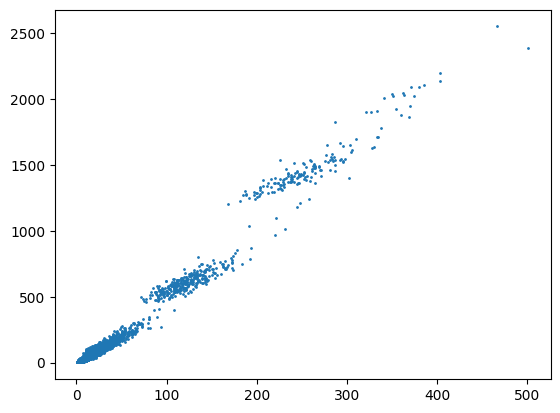

In [10]:
x, y = res["T"], res["A"]
plt.scatter(x, y, s=1)
#plt.plot(np.sort(x), np.sort(x)**1.5, c='r')

## Combine graphs

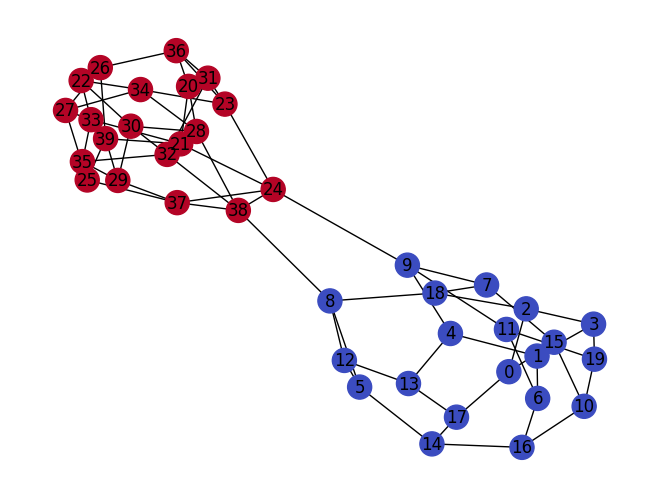

In [38]:
N = 20 # Number of nodes in each graph
p = 0.1 # Coupling probability

# Create two random regular graphs
g1 = nx.random_regular_graph(3, N)
g2 = nx.random_regular_graph(4, N)

# Relabel the nodes in the second graph
g2 = nx.relabel_nodes(g2, {i: i+N for i in g2.nodes})
belongs_to = np.zeros(2*N)
belongs_to[N:] = 1

# Combine the two graphs
g_coupled = nx.Graph()
g_coupled.add_nodes_from(g1.nodes)
g_coupled.add_edges_from(g1.edges)
g_coupled.add_nodes_from(g2.nodes)
g_coupled.add_edges_from(g2.edges)

# Bernoulli distributed coupling
for node in g1.nodes():
    if np.random.random() < p:
        # Choose a node from the second layer randomly
        node_in_layer2 = np.random.choice(list(g2.nodes()))
        g_coupled.add_edge(node, node_in_layer2, inter_layer=True)

nx.draw(g_coupled, with_labels=True, node_color=belongs_to, cmap='coolwarm')

In [1]:
def getCoupledGraph(N, p, g1=None, g2=None):
    # Create two random regular graphs
    if g1 is None: g1 = nx.random_regular_graph(3, N)
    if g2 is None: g2 = nx.random_regular_graph(4, N)

    assert len(g1.nodes) == len(g2.nodes), "g1 and g2 must have the same number of nodes"
    assert N == len(g1.nodes), "N must correspond to the number of nodes"

    # Relabel the nodes in the second graph
    g2 = nx.relabel_nodes(g2, {i: i+N for i in g2.nodes})
    belongs_to = np.zeros(2*N)
    belongs_to[N:] = 1

    # Combine the two graphs
    g_coupled = nx.Graph()
    g_coupled.add_nodes_from(g1.nodes)
    g_coupled.add_edges_from(g1.edges)
    g_coupled.add_nodes_from(g2.nodes)
    g_coupled.add_edges_from(g2.edges)

    # Bernoulli distributed coupling
    for node in g1.nodes():
        if np.random.random() < p:
            # Choose a node from the second layer randomly
            node_in_layer2 = np.random.choice(list(g2.nodes()))
            g_coupled.add_edge(node, node_in_layer2, inter_layer=True)

    return g_coupled, belongs_to

In [34]:
def coupledDynamics(g, belogs_to, f, iterations, p):
    N = g.number_of_nodes()
    degree = [d for _, d in g.degree()]

    load = np.zeros(N)
    critical_load = np.array(degree)

    res = pd.DataFrame({
        "p": [],
        "iteration": [],
        "started_in": [],
        "A_0": [],
        "A_1": [],
    })

    # Run the simulation
    for i in tqdm(range(int(iterations))):
        unstable_queue = []

        # Select a random node
        node = np.random.randint(N)
        
        # Update the load of the selected node
        load[node] += 1

        # Check if the node has become unstable
        if load[node] > critical_load[node]:
            unstable_queue.append(node)
            started_in = belogs_to[node]

        # Solve unstable queue
        A_0 = 0 # Avalanche size (ended in layer 0)
        A_1 = 0 # Avalanche size (ended in layer 1)
        while len(unstable_queue) > 0:
            # Pick the first node in the queue
            node = unstable_queue.pop(0)
            
            # Avalanche size counter
            toppled_in = belogs_to[node]
            if toppled_in == 0:
                A_0 += 1
            else:
                A_1 += 1

            # Get the neighbors of the node
            neighbors = list(g.neighbors(node))

            # Sample a fraction of the neighbors
            to_keep = np.random.rand(len(neighbors)) > f
            neighbors = [neighbors[i] for i in range(len(neighbors)) if to_keep[i]]

            # Update the load of the neighbors
            load[neighbors] += 1

            # Update the state of the node
            load[node] = 0

            # Check if the neighbors have become unstable
            unstable_neighbors = [n for n in neighbors if load[n] > critical_load[n]]
            if len(unstable_neighbors) > 0:
                unstable_queue.extend(unstable_neighbors)
                unstable_queue = list(set(unstable_queue))

        if A_0 > 0 or A_1 > 0:
            res.loc[len(res)] = {
                "p": p,
                "iteration": i,
                "started_in": started_in,
                "A_0": A_0,
                "A_1": A_1,
            }    

    return res

In [49]:
res

,iteration,started_in,A_0,A_1
0,659,0.0,1,0
1,1040,0.0,1,0
2,1359,0.0,1,0
3,1408,0.0,1,0
4,1458,0.0,1,0
...,...,...,...,...
52369,199988,0.0,1,1
52370,199990,0.0,2,0
52371,199994,1.0,0,1
52372,199997,0.0,1,0


In [42]:
g_coupled, belongs_to = getCoupledGraph(1_000, 0.3)
res = coupledDynamics(g_coupled, belongs_to, 0.01, 2e5)

100%|██████████| 200000/200000 [01:03<00:00, 3137.15it/s]


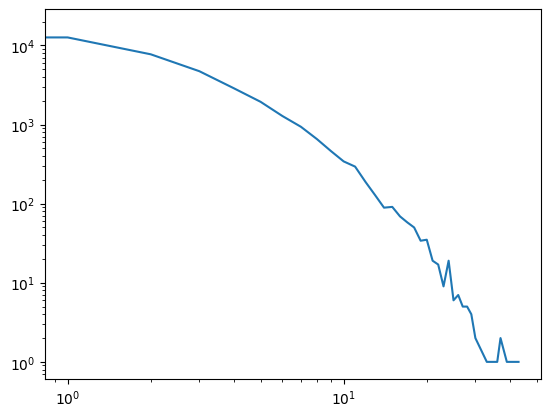

In [48]:
ok = res.groupby("A_0", as_index=False).count()
plt.plot(ok["A_0"], ok["iteration"])
plt.xscale("log")
plt.yscale("log")